In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import glob
import itertools
import skimage.color
import skimage.segmentation
import skimage.graph
import skimage.future
import skimage.exposure
import skimage.filters
import skimage.filters.rank
import skimage.morphology
import re
%matplotlib inline

# Plans

In [73]:
def permutations(array, n=None, perm=[]):
    if n == None:
        n = len(array)
    if n == 0:
        yield perm
    else:
        for i in range(len(array)):
            yield from permutations(array[:i] + array[i + 1:], n - 1,
                                    perm + [array[i]])
def all_plans():
    yield from permutations(list(range(5)), 3)


PLANS = list(all_plans())
COLORS = np.array([[0, 124, 176], [208, 93, 40], [14, 14, 16], [97, 153, 59],
          [247, 181, 0]], dtype=np.uint8)
LABELS = ['blue', 'orange', 'black', 'green', 'yellow']
COLORS

array([[  0, 124, 176],
       [208,  93,  40],
       [ 14,  14,  16],
       [ 97, 153,  59],
       [247, 181,   0]], dtype=uint8)

# Original colors

[[ 99 255 176]
 [  9 206 208]
 [120  32  16]
 [ 48 157 153]
 [ 22 255 247]]


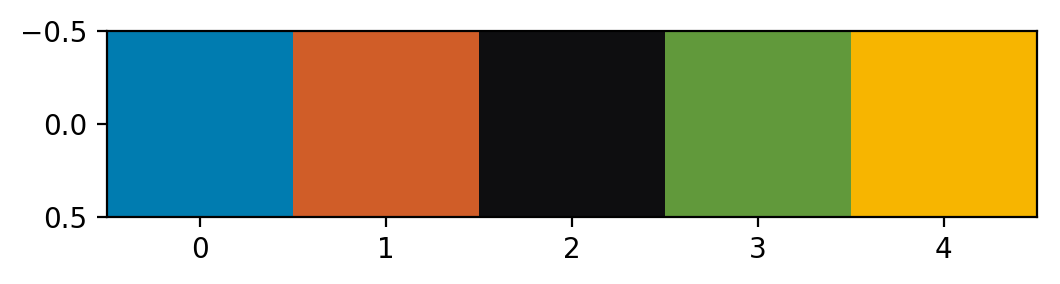

In [3]:
orig_colors_img = np.array([COLORS])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(orig_colors_img)
HSV_COLORS = cv2.cvtColor(orig_colors_img, cv2.COLOR_RGB2HSV)[0]
print(HSV_COLORS)

# Show image

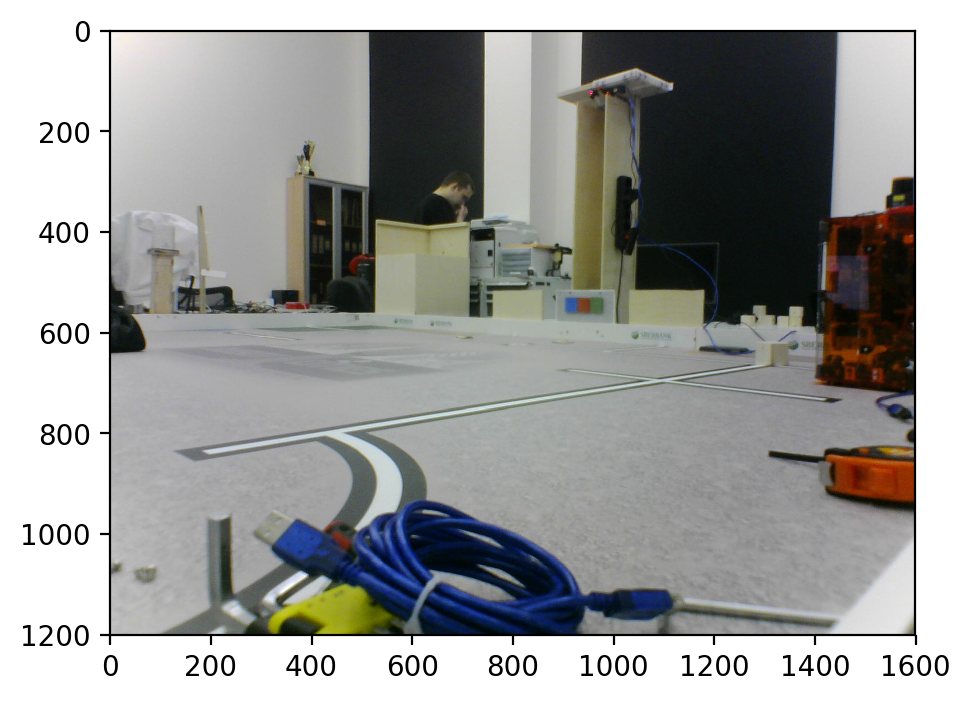

In [166]:
n_transformation = 1
raw_img = cv2.cvtColor(cv2.imread("old_imgs/013.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(raw_img);

# Filtering original image

C:\Users\Mikhail\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


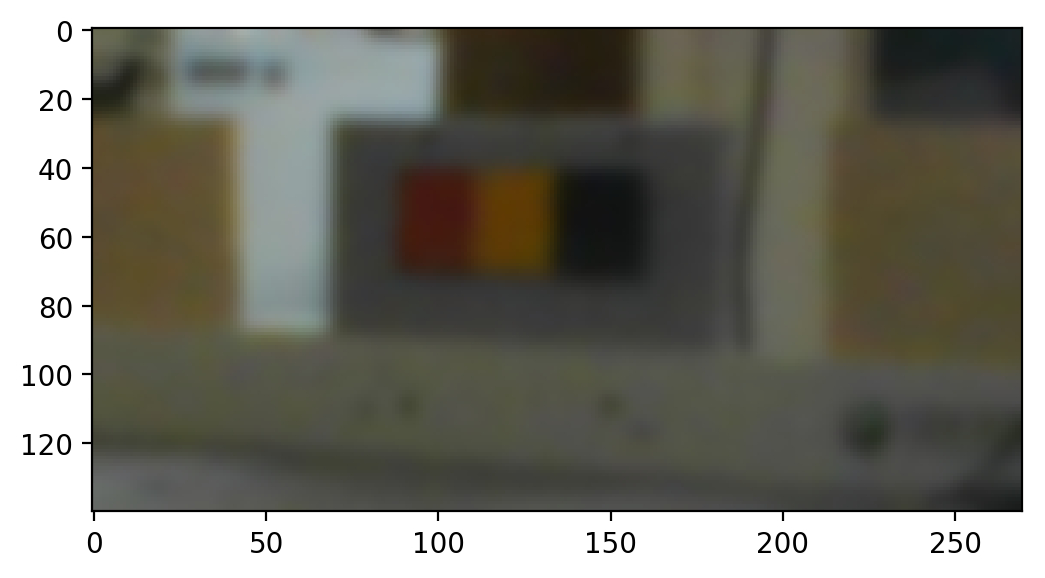

In [143]:
img_small_1 = raw_img[460:600, 730:1000]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
img_small_1 = (skimage.filters.gaussian(img_small_1, 2) * 255).astype(np.uint8)
# img1 = img_small_1 / 255.
# c = -0.10
# laplace_img = img1
# laplace_img1 = np.zeros_like(laplace_img)
# for ch in range(3):
#     laplace_img1[:, :, ch] = skimage.filters.laplace(laplace_img[:, :, ch], ksize=6)
# laplace_img = c * laplace_img1 + laplace_img
# laplace_img = (laplace_img.clip(0, 1))
# img_small_1 = (laplace_img * 255).astype(np.uint8)
ax.imshow(img_small_1);

# Projection transformation

In [146]:
step = 4

In [169]:
def transformation_params(n):
    img_points = [np.float32([(743, 590), (744, 527), (860, 528), (861, 596)]),
                  np.float32([(798, 549), (798, 488), (912, 487), (912, 553)]), 
                  np.float32([(798, 549), (798, 488), (912, 487), (912, 553)]) - np.float32((730, 460))][n]
    h_border = [3 * step * 2, 3 * step * 2, 3 * step * 2][n]
    w_border = [20 * step * 2, 7 * step * 2, 7 * step * 2][n]
    h_rect = int(130 / 30 * step)
    w_rect = int(300 / 30 * step)
    dw = (w_border - w_rect) / 2
    dh = (h_border - h_rect) / 2
    real_points = np.float32([(dw, h_border - dh), (dw, dh), 
                              (w_border - dw, dh), (w_border - dw, h_border - dh)])
    M = cv2.getPerspectiveTransform(img_points, real_points)
    return M, (w_border, h_border)

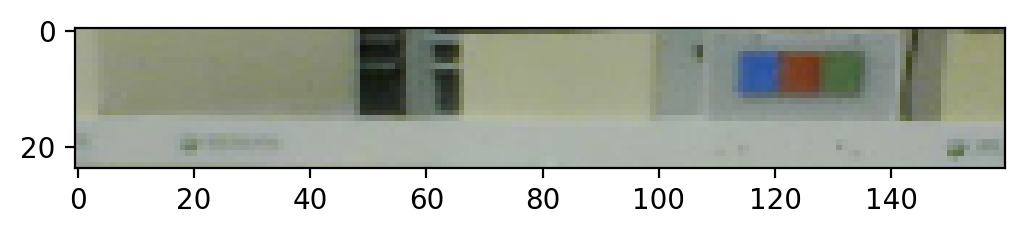

In [172]:
n_transform = 0
small_img = cv2.warpPerspective(raw_img, *transformation_params(n_transform))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(small_img);

# Small image filtration

## HSV

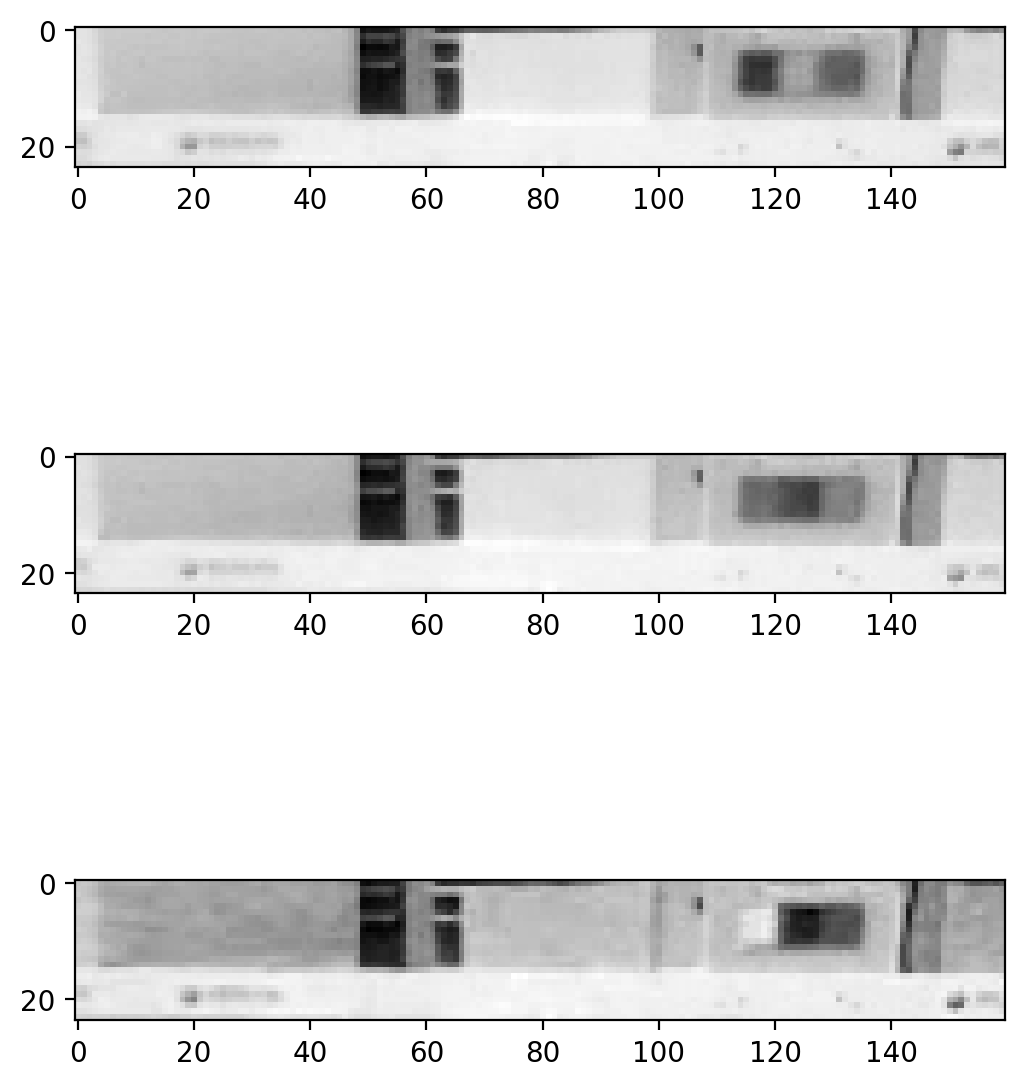

In [175]:
img = small_img.copy()
# img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
fig, ax = plt.subplots(3, 1, figsize=(6, 8), dpi=200)
for i in range(3):
    ax[i].imshow(img[:, :, i], cmap="gray");

## Contour detection

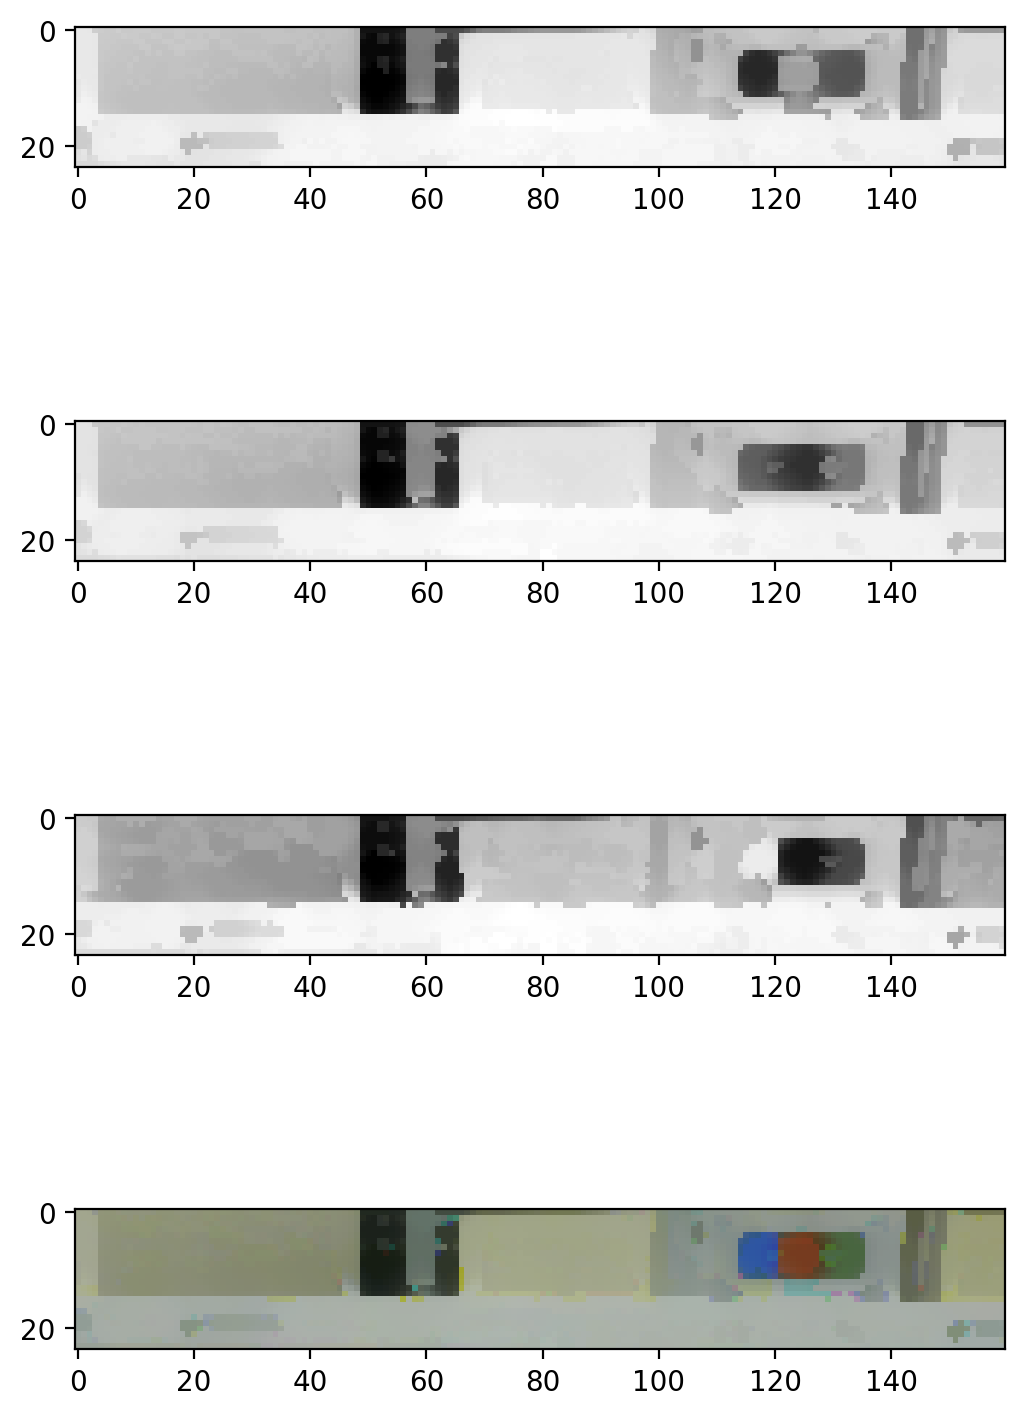

In [174]:
# hsv_img = cv2.cvtColor(small_img, cv2.COLOR_RGB2HSV)
img = gaus_img.copy()
fig, ax = plt.subplots(4, 1, figsize=(6, 10), dpi=200)
for i in range(3):
    selem = skimage.morphology.selem.diamond(2)
    img_ = skimage.filters.rank.enhance_contrast(img[:, :, i], selem)
    if True:
        img[:, :, i] = img_
    ax[i].imshow(img_, cmap="gray");
ax[3].imshow(img)
contour_img = img

## Gauss

C:\Users\Mikhail\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


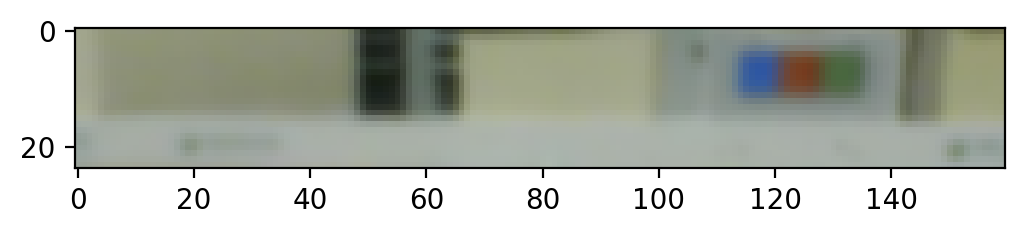

In [173]:
# img2 = cv2.cvtColor(small_img, cv2.COLOR_RGB2HSV)
# img2[:, :, 1] = skimage.exposure.adjust_sigmoid(img2[:, :, 1], 0.25, 10)
# img2[:, :, 2] = skimage.exposure.adjust_sigmoid(img2[:, :, 2], 0.30, 10)
# gaus_img = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
gaus_img = small_img
gaus_img = (skimage.filters.gaussian(gaus_img) * 255).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

# img_1 = gaus_img
# c = -0.50
# img_1 = c * cv2.Laplacian(img_1 / 255, cv2.CV_64F) + img_1 / 255
# img_1 = (255 * img_1.clip(0, 1)).astype(np.uint8)
# gaus_img=img_1

# img2 = cv2.cvtColor(gaus_img, cv2.COLOR_RGB2HSV)
# img2[:, :, 1] = skimage.exposure.adjust_sigmoid(img2[:, :, 1], 0.25, 10)
# img2[:, :, 2] = skimage.exposure.adjust_sigmoid(img2[:, :, 2], 0.30, 10)
# gaus_img = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
ax.imshow(gaus_img);

## Clahe + median

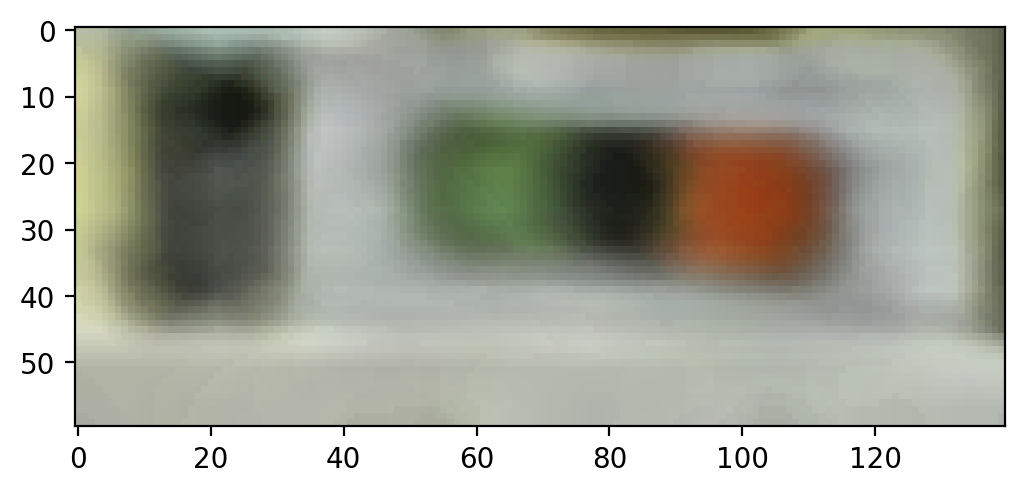

In [32]:
vl = int(step / 4)
img_1 = cv2.medianBlur(small_img, step - 1 + step % 2)
clh_img = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img[:, :, 2] = clahe.apply(clh_img[:, :, 2])
clh_img = cv2.cvtColor(clh_img, cv2.COLOR_HSV2RGB)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img);

## median + clh + contrast correction

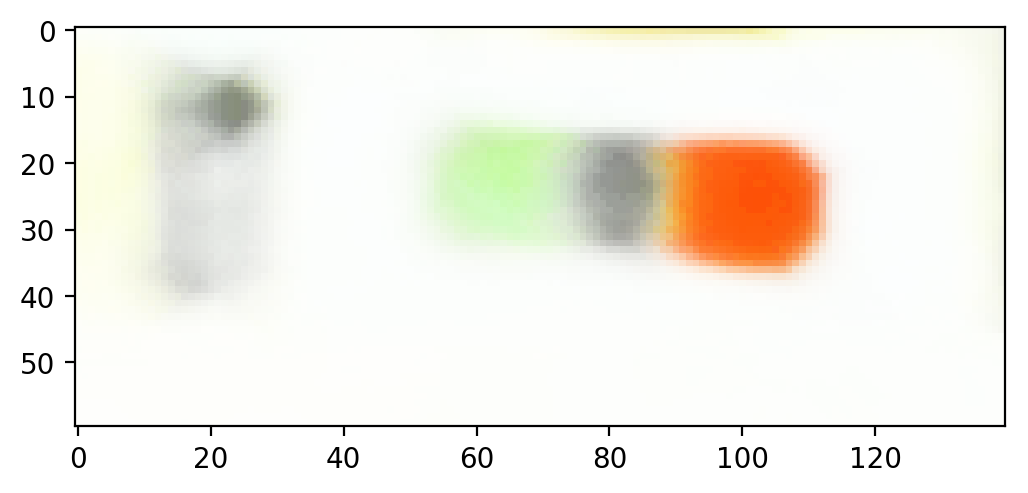

In [34]:
vl = int(step / 4)
img_1 = cv2.medianBlur(small_img, step - 1 + step % 2)

clh_img = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img[:, :, 2] = clahe.apply(clh_img[:, :, 2])
clh_img = cv2.cvtColor(clh_img, cv2.COLOR_HSV2RGB)

img2 = cv2.cvtColor(clh_img, cv2.COLOR_RGB2HSV)
img2[:, :, 1] = skimage.exposure.adjust_sigmoid(img2[:, :, 1], 0.5, 10)
img2[:, :, 2] = skimage.exposure.adjust_sigmoid(img2[:, :, 2], np.mean(img2[:, :, 1] / 255), 10)
# img2[:, :, 1] = np.where(img2[:, :, 1] > np.mean(img2[:, :, 1]), 255, 0)
# img2[:, :, 2] = np.where(img2[:, :, 2] > 125, 255, 2 * img2[:, :, 2])
img2 = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
clh_contr_img = img2
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(img2, cmap="gray");

## Laplacian + CLh + median

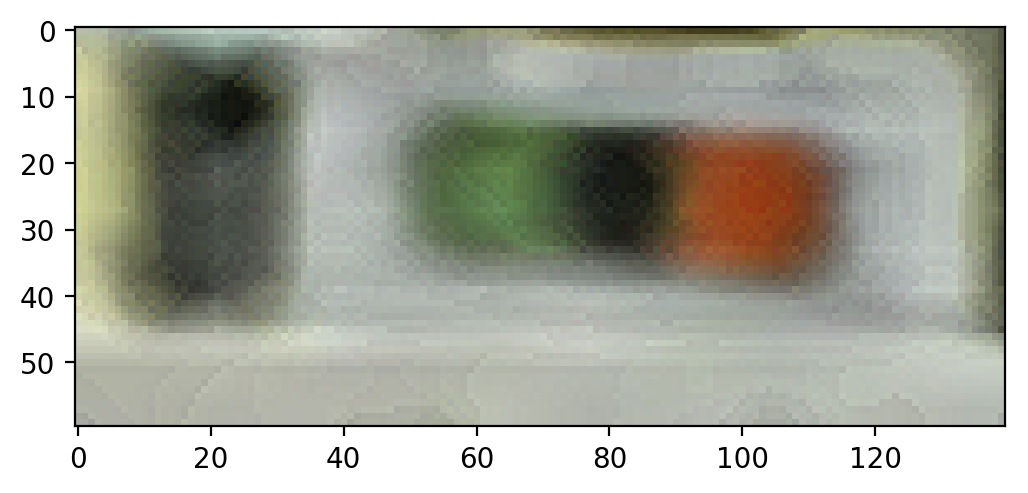

In [35]:
#img_1 = cv2.GaussianBlur(small_img,(13,13),10)
vl = int(step)
img_1 = cv2.medianBlur(small_img, vl - 1 + vl % 2)

clh_img_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2HSV)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(step, step))
clh_img_1[:, :, 2] = clahe.apply(clh_img_1[:, :, 2])
clh_img_1 = cv2.cvtColor(clh_img_1, cv2.COLOR_HSV2RGB)

img_1 = clh_img_1
c = -0.50
img_1 = c * cv2.Laplacian(img_1 / 255, cv2.CV_64F) + img_1 / 255
img_1 = (255 * img_1.clip(0, 1)).astype(np.uint8)
clh_img_1 = img_1

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(clh_img_1);

# RAG

Wall time: 147 ms


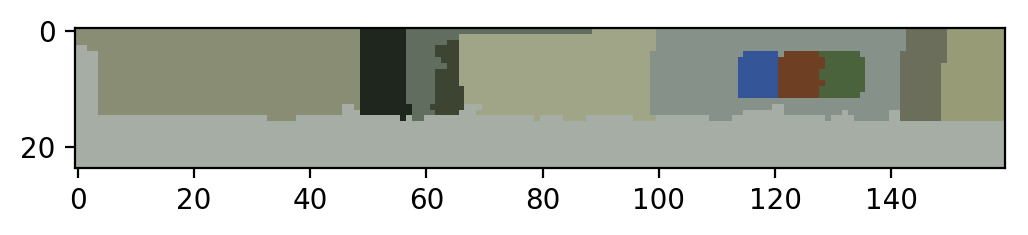

In [176]:
%%time
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}
def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])
input_img = contour_img
h, w = input_img.shape[:2]

labels = skimage.segmentation.slic(input_img, compactness=10, n_segments=h * w // 80)
g = skimage.future.graph.rag_mean_color(input_img, labels)

labels2 = skimage.future.graph.merge_hierarchical(labels, g, thresh=30, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

rag_img = skimage.color.label2rgb(labels2, input_img, kind='avg')
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(rag_img);

## Contrast correction

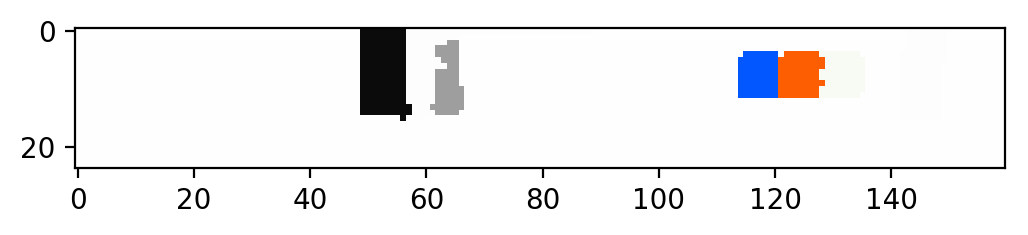

In [177]:
img2 = cv2.cvtColor(rag_img, cv2.COLOR_RGB2HSV)
# img2[:, :, 1] = skimage.exposure.adjust_gamma(img2[:, :, 1], gamma=2, gain=1)
# img2[:, :, 2] = skimage.exposure.adjust_gamma(img2[:, :, 2], gamma=0.5, gain=1)
img2[:, :, 1] = skimage.exposure.adjust_sigmoid(img2[:, :, 1], 0.5, 30)
img2[:, :, 2] = skimage.exposure.adjust_sigmoid(img2[:, :, 2], 0.25, 30)
rag_img_contr = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(rag_img_contr)

# Cube sequence searching

In [178]:
def get_distances_skimage(input_img):
    lab_COLORS = skimage.color.rgb2lab(COLORS[np.newaxis, :, :])[0]
    lab_img = skimage.color.rgb2lab(input_img)
    dist_array = skimage.color.deltaE_cmc(lab_img[:, :, np.newaxis], lab_COLORS[np.newaxis, np.newaxis, :],
                                          2, 1)
    return dist_array
def determ_color(color):
    return np.argmin(get_distances_skimage(np.array([[
        color.astype(np.uint8)]]))[0, 0]), color

In [179]:
labels = labels2
n = np.max(labels)
xc = np.zeros(n)
yc = np.zeros(n)
xr = np.zeros(n)
yr = np.zeros(n)

h, w = labels.shape[0:2]
x = np.arange(w)
y = np.arange(h)

for i in range(n):
    m = np.count_nonzero(labels == i)
    xc[i] = np.sum(x[np.newaxis, :] * (labels == i)) / m
    yc[i] = np.sum(y[:, np.newaxis] * (labels == i)) / m
    
    xr[i] = (np.sum(((x[np.newaxis, :] - xc[i]) * (labels == i)) ** 2) / m) ** 0.5
    yr[i] = (np.sum(((y[:, np.newaxis] - yc[i]) * (labels == i)) ** 2) / m) ** 0.5

In [180]:
r = step / np.sqrt(3)
k1 = 1
k2 = 1
cost_function = np.zeros((n, n, n))
for i, j, k in itertools.product(range(n), range(n), range(n)):
    if (i != j) and (j != k) and (k != i) and (xc[k] >= xc[j]) and (xc[j] >= xc[i]):
        cost_function[i, j, k] =\
        k1 * ((xr[i] - r) ** 2 + (yr[i] - r) ** 2 +\
              (xr[j] - r) ** 2 + (yr[j] - r) ** 2 +\
              (xr[k] - r) ** 2 + (yr[k] - r) ** 2) +\
        k2 * ((yc[i] - yc[j]) ** 2 + (xc[j] - xc[i] - step * 2) ** 2 +\
              (yc[j] - yc[k]) ** 2 + (xc[k] - xc[j] - step * 2) ** 2 +\
              (yc[k] - yc[i]) ** 2 + (xc[k] - xc[i] - step * 4) ** 2)
    else:
        cost_function[i, j, k] = np.inf

In [181]:
ind = np.unravel_index(np.argmin(cost_function), (n, n, n))
ind

(7, 8, 9)

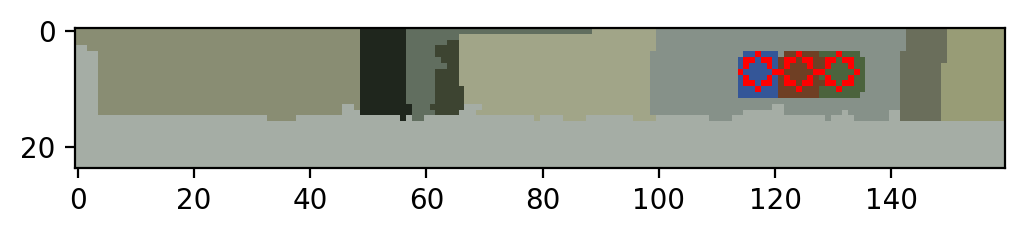

In [182]:
input_img = rag_img.copy()

for i in ind:
    cv2.circle(input_img, (int(xc[i]), int(yc[i])), 
               int((3 * yr[i] ** 2 / 2 + 3 * yr[i] ** 2 / 2) ** 0.5), (255, 0, 0), 1)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(input_img);

[2 2 2]


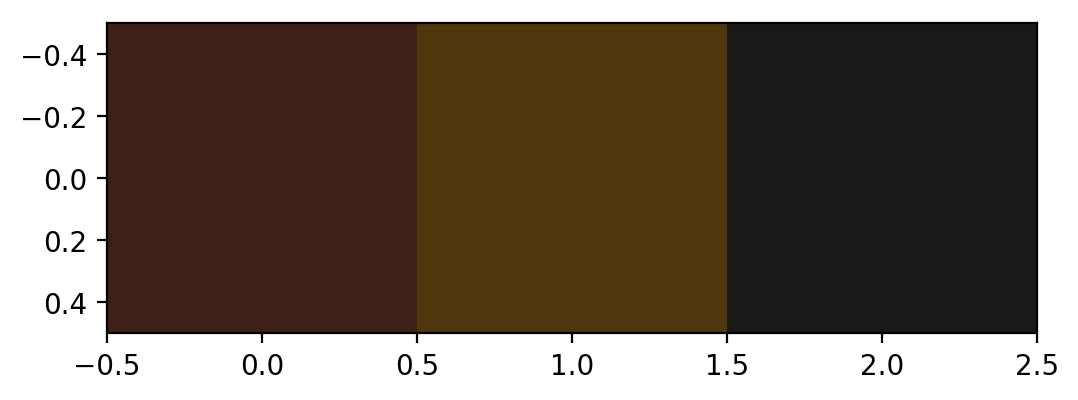

In [164]:
input_img = small_img
hsv_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2HSV)

best_plan = np.zeros(3, dtype=np.uint8)
colors = np.zeros((3, 3), dtype=np.uint8)
for j, i in enumerate(ind):
    m = np.count_nonzero(labels == i)
    color = np.sum(np.sum(input_img.astype(np.float32) *\
        (labels == i)[:, :, np.newaxis], axis=0), axis=0) / m
    best_plan[j], colors[j] = determ_color(color)
print(best_plan)
colors_img = np.array([colors])
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
# ax.set_title([LABELS[PLANS[best_plan][x]] for x in range(3)])
ax.imshow(colors_img)

# Test on many images

In [8]:
import sys
sys.path.insert(0, r"/home/mikhail/catkin_ws/src/ros-eurobot-2018/eurobot_camera/src/scripts/")
from PlanRecognition import find_colors, img_transformation, get_distances_skimage, rag, find_colors_geom

In [9]:
params = {"kl":2, 
          "kp":1,
          "k1":1,
          "k2":1,
          "kr":1,
          "thresh":40,
          "s_cutoff":0.25,
          "s_gain":30,
          "v_cutoff":0.25,
          "v_gain":40,
          "c":-0.45}

In [10]:
files = glob.glob("old_imgs/*.png")
plans = [[int(x_) for x_ in re.search("\S+(\d\d\d)\S+", x).group(1)] for x in files]
n_files = len(files)
n_errors = 0
for file, plan in zip(files, plans):
    img_ = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img_ = cv2.warpPerspective(img_, M1, (w_border1, h_border1))    
    found_plan = find_colors_geom(img_, **params)[0]
    print(found_plan, plan, file)
    if found_plan != plan:
        print(False)
        n_errors += 1
print("Errors: %d from %d" % (n_errors, n_files))

[3, 2, 3] [2, 0, 3] old_imgs/203.png
False
[2, 3, 3] [3, 1, 4] old_imgs/314_1.png
False
[1, 4, 0] [1, 4, 0] old_imgs/140_2.png
[3, 3, 3] [2, 4, 1] old_imgs/241.png
False
[3, 3, 3] [2, 1, 3] old_imgs/213_1.png
False
[0, 1, 2] [0, 1, 2] old_imgs/012_1.png
[0, 2, 3] [0, 2, 3] old_imgs/023.png
[0, 3, 4] [0, 3, 4] old_imgs/034_1.png
[2, 1, 3] [2, 1, 3] old_imgs/213.png
[0, 3, 4] [0, 3, 4] old_imgs/034_2.png
[1, 3, 4] [1, 3, 4] old_imgs/134.png
[3, 1, 4] [3, 1, 4] old_imgs/314.png
[2, 2, 3] [0, 3, 1] old_imgs/031_1.png
False
[4, 1, 3] [4, 1, 3] old_imgs/413.png
[0, 3, 1] [0, 3, 1] old_imgs/031.png
[1, 3, 4] [1, 3, 4] old_imgs/134_2.png
[0, 1, 3] [0, 1, 3] old_imgs/013.png
[2, 1, 2] [1, 4, 0] old_imgs/140.png
False
[3, 3, 3] [4, 3, 2] old_imgs/432.png
False
[0, 1, 2] [0, 1, 2] old_imgs/012.png
[3, 3, 3] [3, 4, 0] old_imgs/340.png
False
[4, 3, 1] [4, 3, 1] old_imgs/431.png
[3, 3, 3] [1, 2, 3] old_imgs/123_1.png
False
[0, 3, 4] [0, 3, 4] old_imgs/034.png
[2, 3, 1] [2, 3, 1] old_imgs/231.png
[0,

In [11]:
files = glob.glob("imgs/*.png")
plans = [[int(x_) for x_ in re.search("\S+(\d\d\d)\S+", x).group(1)] for x in files]
n_files = len(files)
n_errors = 0
for file, plan in zip(files, plans):
    img_ = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img_ = cv2.warpPerspective(img_, M2, (w_border2, h_border2))    
    found_plan = find_colors_geom(img_, **params)[0]
    print(found_plan, plan, file)
    if found_plan != plan:
        print(False)
        n_errors += 1
print("Errors: %d from %d" % (n_errors, n_files))

[3, 2, 1] [3, 2, 1] imgs/321_4.png
[3, 2, 1] [3, 2, 1] imgs/321_5.png
[3, 2, 1] [3, 2, 1] imgs/321_7.png
[3, 2, 0] [3, 2, 0] imgs/320_1.png
[3, 2, 0] [3, 2, 0] imgs/320_3.png
[0, 4, 1] [0, 4, 1] imgs/041_1.png
[3, 2, 0] [3, 2, 0] imgs/320_2.png
[3, 2, 1] [3, 2, 1] imgs/321_6.png
[3, 2, 1] [3, 2, 1] imgs/321_1.png
[0, 4, 1] [0, 4, 1] imgs/041_2.png
[3, 4, 0] [3, 4, 0] imgs/340.png
[3, 2, 0] [3, 2, 0] imgs/320_5.png
[0, 4, 1] [0, 4, 1] imgs/041.png
[0, 4, 1] [0, 4, 1] imgs/041_4.png
[0, 4, 1] [0, 4, 1] imgs/041_3.png
[0, 4, 2] [0, 4, 2] imgs/042.png
[3, 2, 0] [3, 2, 0] imgs/320_4.png
[3, 2, 1] [3, 2, 1] imgs/321_2.png
[3, 2, 1] [3, 2, 1] imgs/321_8.png
[3, 2, 1] [3, 2, 1] imgs/321_3.png
[1, 4, 2] [1, 4, 2] imgs/142_1.png
[1, 2, 2] [1, 4, 2] imgs/142.png
False
Errors: 1 from 22


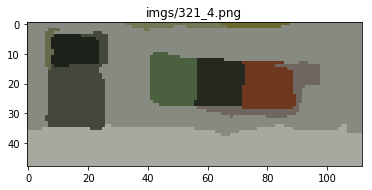

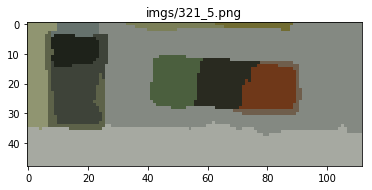

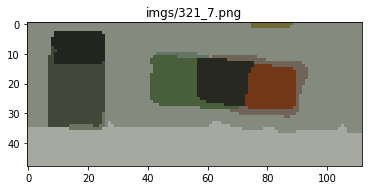

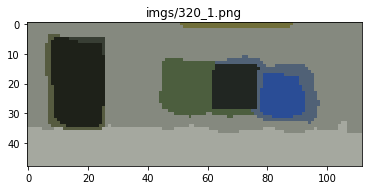

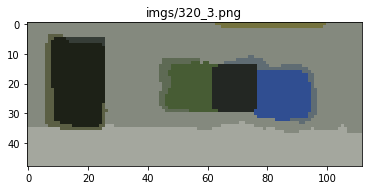

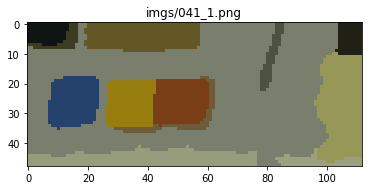

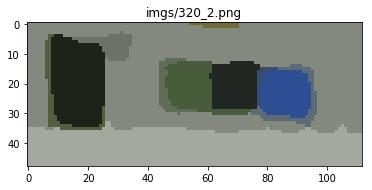

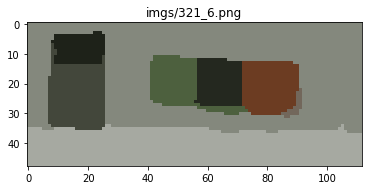

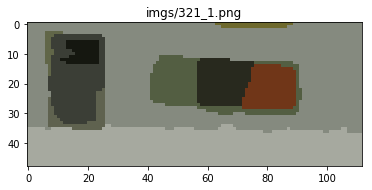

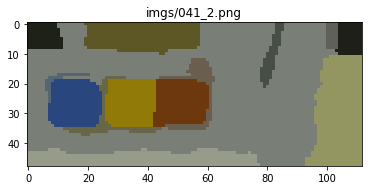

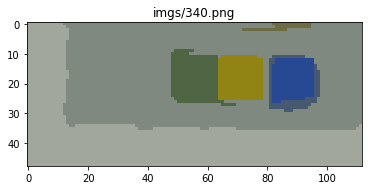

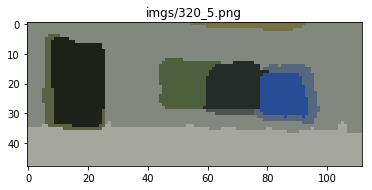

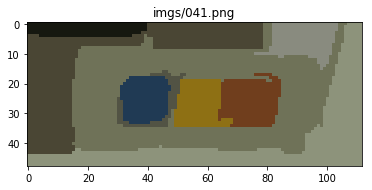

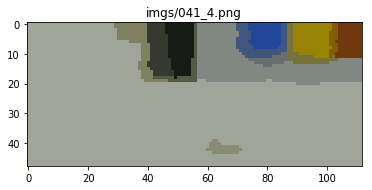

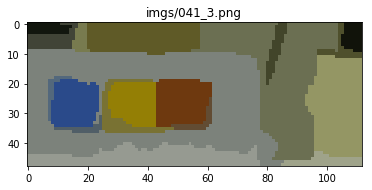

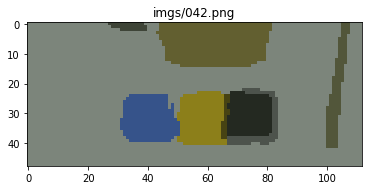

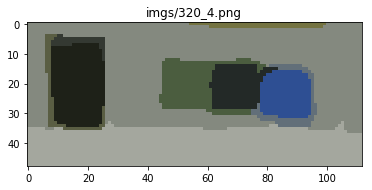

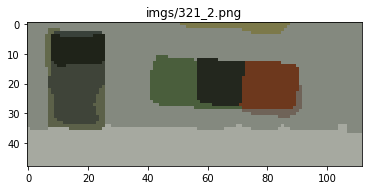

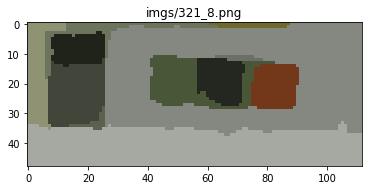

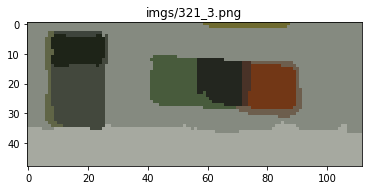

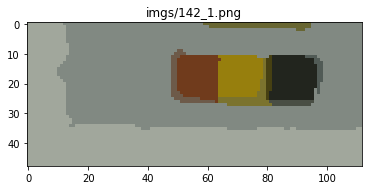

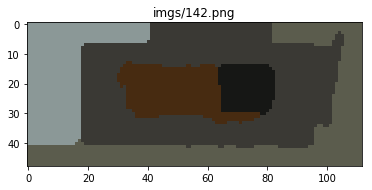

In [12]:
files = glob.glob("imgs/*.png")
# files = glob.glob("imgs/.png")
plans = [[int(x_) for x_ in re.search("\S+(\d\d\d)\S+", x).group(1)] for x in files]
for file, plan in zip(files, plans):
    img_ = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img_ = cv2.warpPerspective(img_, M, (w_border, h_border))    
    _, colors, _ = find_colors_geom(img_, **params)
    plt.imshow(rag(img_, **params)[0])
    plt.title(file)
    plt.show()

# Color metric

In [85]:
diff_colors = np.random.randint(0, 256, (200, 3), dtype=np.uint8)

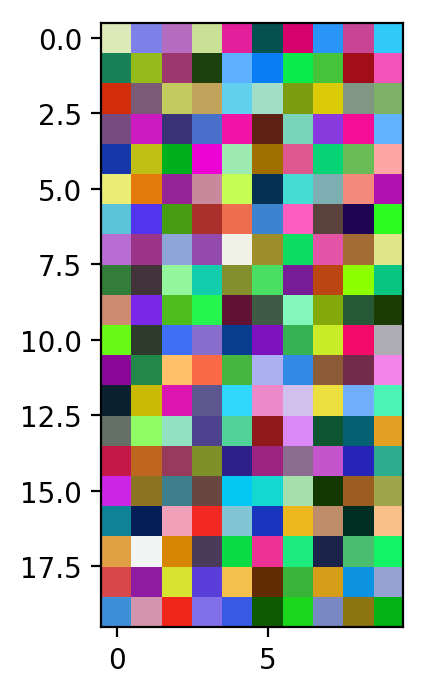

In [86]:
diff_colors_img = diff_colors.reshape(diff_colors.shape[0] // 10, 10, 3)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(diff_colors_img)

In [279]:
colors_dist_ecmc = np.zeros((diff_colors.shape[0], COLORS.shape[0]))
for i in range(COLORS.shape[0]):
    colors_dist_ecmc[:, i] =\
    np.apply_along_axis(color_distance, 1, diff_colors, COLORS[i])

In [280]:
def make_distance_img(colors_dist):
    to_colors = np.argmax(colors_dist, axis=1)
    diff_colors_1 = [(x_, y_, z_) for x_, y_, z_ in zip(diff_colors, 
                     np.argmin(colors_dist, axis=1), np.min(colors_dist, axis=1))]
    imgs = [None] * COLORS.shape[0]
    for i in range(COLORS.shape[0]):
        cols = [(x_[0], x_[2]) for x_ in diff_colors_1 if x_[1] == i]
        cols = sorted(cols, key = lambda x_: x_[1])
        cols = [x_[0] for x_ in cols]
        n = len(cols) + 1
        imgs[i] = np.array([COLORS[i]] + cols + ((10 - n % 10) % 10) * [[255, 255, 255]], 
                           dtype=np.uint8)
        imgs[i] = imgs[i].reshape(imgs[i].shape[0] // 10, 10, 3)
    return np.concatenate(imgs, axis=0)

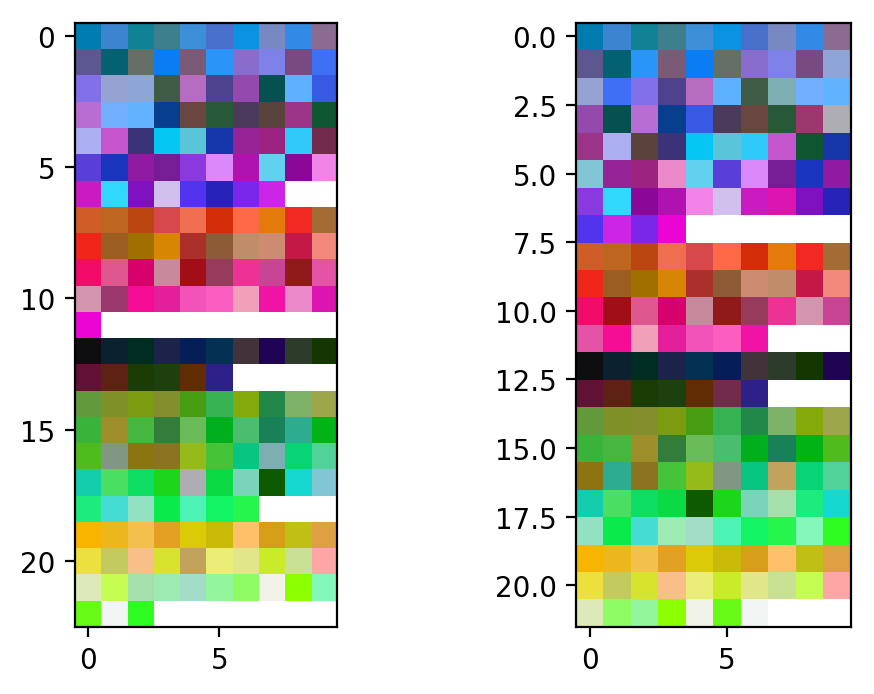

In [288]:
fig, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(make_distance_img(colors_dist_lab2))
ax[1].imshow(make_distance_img(colors_dist_lab))